![AES CEE Masthead](https://kyrill.ias.sdsmt.edu/wjc/eduresources/AES_CEE_Masthead.png)
# Extracting and Locally Archiving NCEI Daily GHCN (GHCND)

## Introduction

This Jupyter notebook shows how to use Python to navigate the [NCEI NOAA Climate Data Online Web services (Version 2)](https://www.ncdc.noaa.gov/cdo-web/webservices/v2).  As with the [USGS National Water Information System (NWIS)](https://nwis.waterdata.usgs.gov/nwis), CDO allows data pulls using a web-service query system.  

Most casual users can access this resource through a human-friendly web system. However, for those who are more demanding and particular about their searches and what they do with them, we may need to pull and process data in bulk. 

Python and R have various tools for accessing organizations' web services and pulling data. For NCEI, I have used a basic query/retrieval toolbox called [pyncei](https://github.com/adamancer/pyncei), developed by Adam Mansur at the Smithsonian.

This session is split into two parts.  

The first part is an orientation to the system and shows how to request, retrieve, and process the data into a workable Pandas DataFrame.

The second part takes this process further and sets the stage for a more automated process, saving the results as a netCDF file accessible remotely and is also compliant with community expectations of shared data.  If you are going to invest time in making a saveable dataset, you should play for keeps!


---
## Libraries

For this demo, you will need the following libraries.

Note that the primary library (pyncei) must be installed manually through GitHub and not through pip or conda.

The Basics...

* [numpy](https://numpy.org/): Python's "go-to" library for math and array/matrix structures
* [matplotlib](https://matplotlib.org/stable/): Python's "go-to" Graphics Library.
* [pandas](https://pandas.pydata.org/): A visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
* [geopandas](https://geopandas.org/en/stable/): Extends the datatypes used by pandas to allow geospatial spatial operations on geometric types such as points, lines and polygons in maps.
* [seaborn](https://seaborn.pydata.org/index.html): a library for making statistical graphics in Python. It builds on top of matplotlib and integrates closely with pandas data structures.
* [xarray](https://docs.xarray.dev/en/stable/): A package for working with complex array data, especially those extracted from self-describing files like netCDF (and also very helpful in writing netCDF files).


Mapping Resources (When running this as a general Python script, you won't want this part.) You can learn how to use these libraries in the tutorial making [WRF Model Domains](https://wjcapehart.github.io/AES_CEE_Python/Jupyter_Notebooks_and_Other_Files/03_Deep_Dives/03_02_Applications/03_02_05_WRF_Domain_Mapping/WRF_Map_Out_Namelist_WPS.html).

* [CartoPy](https://scitools.org.uk/cartopy/docs/latest/): A map projection library. We are specifically requesting the following sublibaries
    * [CartoPy.crs](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html): Cartopy's Coordinate Reference System (CRS) operators. This is the information needed to draw the various projections.
    * [CartoPy.feature](https://scitools.org.uk/cartopy/docs/latest/reference/feature.html): Cartopy's Feature Plotting Interface
    * [CartoPy.io.img_tiles](https://scitools.org.uk/cartopy/docs/latest/reference/io.html#module-cartopy.io.img_tiles): Access to Mapping Tiles
    * [CartoPy.mpl](https://scitools.org.uk/cartopy/docs/latest/reference/matplotlib.html#module-cartopy.mpl): Cartopy Matplotlib Interface


More specialized libraries will need special attention.

* [cf-xarray](https://cf-xarray.readthedocs.io/en/latest/): an accessor python package that allow the user to modify xarray datasets to be better compliant with the [Climate and Forecast (CF) Metadata Conventions](https://cfconventions.org/).

* [pyncei](https://github.com/adamancer/pyncei): The closest python package there is to the defunct rNOAA package from R.  The code reaches into the [NCEI NOAA Climate Data Online Web services (Version 2)](https://www.ncdc.noaa.gov/cdo-web/webservices/v2).  However, NOAA programmers did not develop it; rather, it was developed by Adam Mansur, a programmer from the Smithsonian.  Presently, this code is installed directly from the GitHub link (above in the title) by cloning the GitHub image and compiling it locally following [these instructions](https://github.com/adamancer/pyncei/issues/5#issuecomment-1949200164).

* [itables](https://mwouts.github.io/itables/): A Juptyer extension that will allow your tables to be displayed in a manner similar to RStudio by which you can scroll through them.  If you have big or wide tables, this is what you need to explore your data.  Be aware that you should comment it out if you export your file into a plain *.py executable.  To activate, you must invoke the command, [itables.init_notebook_mode()](https://mwouts.github.io/itables/pandas_style.html)

Non-Library iPython Resource...

* [version_information](https://github.com/jrjohansson/version_information): Package version documentation to aid in replicability. See its use at the in the next block of code in this notebook.  You will need to remove this before saving it as a plain Python "*.py" script.


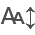

In [1]:
################################################################
#
# Loading Version Information
#

import numpy                as np
import matplotlib.pyplot    as plt

import xarray               as xr
import cf_xarray.datasets   as cf

import pandas               as pd
import geopandas            as gpd
import seaborn              as sns

import cartopy.crs          as ccrs  
import cartopy.feature      as cfeature
import cartopy.io.img_tiles as cimgt
import cartopy.mpl          as cmpl

from pyncei  import            NCEIBot, NCEIResponse
from itables import init_notebook_mode, show

# Initialize itables for your notebook environment

init_notebook_mode(all_interactive = True)

#
################################################################

---

## Activating the NCEI retrieval object (and conveying your access "token")

Before proceeding get your own NCEI CDO Token.  This is needed to register you for the climate services at NCEI.

[https://www.ncdc.noaa.gov/cdo-web/token](https://www.ncdc.noaa.gov/cdo-web/token)

Once secured, you can then create the [pyncei.bot.NCEIBot()](https://pyncei.readthedocs.io/en/latest/api.html#module-pyncei.bot) object and using your token to get you into the NCEI CDO services.





In [2]:
################################################################
#
# Access NCEI CDO Web Services.
#

ncei = NCEIBot(token       = "xxinINENYhApGNjsGZjRpsNbAtSroeky",
               wait        = 10,
               cache_name  = "./",
               max_retries = 20)

#
################################################################

## Viewing NCEI Datasets

The  pyncei.bot.NCEIBot will give you several basic subcommands to query and extract the needed data.  (Most are specific types of queries, such as the kinds of datasets available, the species of data, and specific variables that will help you tunnel down and get you want you need.  

While this tutorial's goal is to access and then curate the necessary data, much of that data will be in a large set of nested loops so for now, we will mimic a session where you search for a given station as we tunnel into the service.

Let's start by browsing the available inventories, data types and variables.

We'll start with [pyncei.bot.NCEIBot.get_datasets](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIBot.get_datasets)

The information returned from the various requests is stored inside of an [NCEI Response object](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIResponse), which could take different forms and structures.  Therefore, to make the user's life easier the data can be sent to [a csv file](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIResponse.to_csv) or locally to [a pandas dataframe](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIResponse.to_dataframe) to make accessing it easier.

In [3]:
################################################################
#
# Display available NCDC CDO Datasets
#

ncei.get_datasets().to_dataframe()

#
################################################################

id                   uid                         name  \
0        GHCND  gov.noaa.ncdc:C00861              Daily Summaries   
1         GSOM  gov.noaa.ncdc:C00946  Global Summary of the Month   
2         GSOY  gov.noaa.ncdc:C00947   Global Summary of the Year   
3      NEXRAD2  gov.noaa.ncdc:C00345     Weather Radar (Level II)   
4      NEXRAD3  gov.noaa.ncdc:C00708    Weather Radar (Level III)   
5   NORMAL_ANN  gov.noaa.ncdc:C00821      Normals Annual/Seasonal   
6   NORMAL_DLY  gov.noaa.ncdc:C00823                Normals Daily   
7   NORMAL_HLY  gov.noaa.ncdc:C00824               Normals Hourly   
8   NORMAL_MLY  gov.noaa.ncdc:C00822              Normals Monthly   
9    PRECIP_15  gov.noaa.ncdc:C00505      Precipitation 15 Minute   
10  PRECIP_HLY  gov.noaa.ncdc:C00313         Precipitation Hourly   

    datacoverage    mindate    maxdate  \
0           1.00 1750-02-01 2024-12-11   
1           1.00 1750-02-01 2024-11-01   
2           1.00 1763-01-01 2024-01-01   
3           0.95 1991-06-05 2024-12-12   
4           0.95 1994-05-20 2024-12-09   
5           1.00 2010-01-01 2010-01-01   
6           1.00 2010-01-01 2010-12-31   
7           1.00 2010-01-01 2010-12-31   
8           1.00 2010-01-01 2010-12-01   
9           0.25 1970-05-12 2014-01-01   
10          1.00 1900-01-01 2014-01-01   

                                                  url           retrieved  
0   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
1   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
2   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
3   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
4   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
5   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
6   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
7   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
8   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
9   https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05  
10  https://www.ncdc.noaa.gov/cdo-web/api/v2/datas... 2024-12-14 02:23:05

## Exploring the Available Data in the GHCND datasets

In the end we're only extracting a few variables from the GHCND but just to see what we are about to step in, here are the available variables using [pyncei.bot.NCEIBot.get_data_types()](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIBot.get_data_types).  

Notice you can search by specific datasets (and stations, regions, and time ranges)

In [4]:
################################################################
#
# Access GHCND Variables.
#

display(ncei.get_data_types(datasetid="GHCND").to_dataframe())

#
################################################################

id                                               name  datacoverage  \
0    ACMC  Average cloudiness midnight to midnight from 3...           1.0   
1    ACMH  Average cloudiness midnight to midnight from m...           1.0   
2    ACSC  Average cloudiness sunrise to sunset from 30-s...           1.0   
3    ACSH  Average cloudiness sunrise to sunset from manu...           1.0   
4    AWND                                 Average wind speed           1.0   
..    ...                                                ...           ...   
131  WV01  Fog, ice fog, or freezing fog (may include hea...           1.0   
132  WV03                                            Thunder           1.0   
133  WV07      Ash, dust, sand, or other blowing obstruction           1.0   
134  WV18                               Snow or ice crystals           1.0   
135  WV20                                Rain or snow shower           1.0   

       mindate    maxdate                                                url  \
0   1994-03-19 1996-05-28  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
1   1965-01-01 2005-12-31  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
2   1994-02-01 1996-05-28  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
3   1965-01-01 2005-12-31  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
4   1982-01-01 2024-12-10  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
..         ...        ...                                                ...   
131 1996-07-01 2005-12-24  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
132 1996-07-02 2005-12-31  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
133 1996-07-08 2005-09-09  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
134 1996-10-21 2002-02-04  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   
135 1996-07-01 2005-12-31  https://www.ncdc.noaa.gov/cdo-web/api/v2/datat...   

              retrieved  
0   2024-12-14 02:23:15  
1   2024-12-14 02:23:15  
2   2024-12-14 02:23:15  
3   2024-12-14 02:23:15  
4   2024-12-14 02:23:15  
..                  ...  
131 2024-12-14 02:23:15  
132 2024-12-14 02:23:15  
133 2024-12-14 02:23:15  
134 2024-12-14 02:23:15  
135 2024-12-14 02:23:15  

[136 rows x 7 columns]

Most of the fields in the above dataframe are not included in the data files.  

---
## Let's go Shopping!! (Finding Stations)

To begin looking for stations, we should narrow our search to a region.  There are many ways to zero in.  Below shows the different categories using [pyncei.bot.NCEIBot.get_location_categories()](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIBot.get_location_categories)

"If you know what you're doing," some of the ones below may not make immediate sense, especially the hydrologic descriptions, which are various HUC levels.  Here is an attempt to right that wrong sorted from what's hopefully the most intuitive to the most confusing.

Note that many of these are given digital search codes.  

I also recommend avoiding this feature and starting the location search using the [Climate Data Online Search](https://www.ncdc.noaa.gov/cdo-web/search). 

|   id     |      name      |  name for nerds | we are here; FIPS (name) |
|:--------:|:--------------:|:---------------:|:------------------------:|
|  CNTRY   |     Country    | The plain-language name of the enclosing national boundary  | "FIPS:US"       ("United States") |
| US_TERR  |  US Territory  | The plain-language name of enclosing US dependency boundary |  NA                               |
|    ST    |      State     | The plain-language name of enclosing national boundary      | "FIPS:46"        ("South Dakota") |
|   CNTY   |     County     | The plain-language name of enclosing national boundary      | "FIPS:46103"       ("Pennington") |
|   CITY   |      City      | The plain-language name of the enclosing city boundary      | "CITY:US460006"    ("Rapid City") |
|    ZIP   |    Zip Code    | US 5-digit Postal Code                                      | "ZIP:57701" ("[East] Rapid City") |
| CLIM_REG | Climate Region | [The large-multistate climate zones](https://www.ncei.noaa.gov/access/monitoring/reference-maps/us-climate-regions) | "CLIM:105" ("Northern Rockies and Great Plains") |
|CLIM_DIV  | Climate Division | [The smaller intrastate climate divisions](https://www.ncei.noaa.gov/access/monitoring/reference-maps/conus-climate-divisions) | "CLIM:4604" ("Black Hills")* |
| HYD_REG | Hydrologic Regions         | 2-digit HUC | "HUC:10 ("Missouri")     |
| HYD_SUB | Hydrologic Subregion	   | 4-digit HUC | "HUC:1012" ("Cheyenne")  |
| HYD_ACC | Hydrologic Accounting Unit | 6-digit HUC | "HUC:101201" ("Cheyenne")|
| HYD_CAT | Hydrologic Cataloging Unit | 8-digit HUC | "HUC:10120110" ("Rapid") |


*zones in states with early letters of the alphabet have leading zeros. E.g., the Alabama Northern Valley is "CLIM:0101", not "CLIM:101".


## OK Let's go Shopping, *Efficiently*!! (Pulling Stations given a specific code)

Let's zoom in for now and just get the stations within the 57701 Zip Code Area.

Since this may be useful to retain, we can also write this to a CSV file and a data frame.  For the deeper application, at the close of this session, you will see an example of this.


In [5]:
################################################################
#
# Access GHCND Stations based on geographic criteria
#

zip_code_id = "ZIP:57701"

stations = ncei.get_stations(datasetid  =     "GHCND",
                             locationid = zip_code_id,
                             limit      =        1000)

stations.to_csv(path = "./ZIP_CODE_STATIONS.csv")

stations_df = stations.to_dataframe()

stations_df.set_index('id', inplace=True)

stations_df

#
################################################################

name   latitude  \
id                                                                        
GHCND:US1SDMD0036                  RAPID CITY 6.2 NNE, SD US  44.161073   
GHCND:US1SDPN0036                   RAPID CITY 2.9 SE, SD US  44.041390   
GHCND:US1SDPN0038                   RAPID CITY 3.5 NE, SD US  44.095824   
GHCND:US1SDPN0044                  RAPID CITY 2.0 SSE, SD US  44.048664   
GHCND:US1SDPN0064                    RAPID CITY 3.0 N, SD US  44.117955   
GHCND:US1SDPN0068                  RAPID CITY 2.0 SSE, SD US  44.047851   
GHCND:US1SDPN0074                  RAPID CITY 0.3 SSW, SD US  44.071158   
GHCND:US1SDPN0078                   RAPID CITY 2.2 SE, SD US  44.050026   
GHCND:USC00396936         RAPID CITY STATION NUMBER 1, SD US  44.066660   
GHCND:USC00396947                     RAPID CITY 4 NW, SD US  44.120550   
GHCND:USC00396948  RAPID CITY WEATHER FORECAST OFFICE, SD US  44.072700   

                    longitude  elevation elevationUnit  datacoverage  \
id                                                                     
GHCND:US1SDMD0036 -103.197391      985.7        METERS        0.1715   
GHCND:US1SDPN0036 -103.199418      993.3        METERS        0.3783   
GHCND:US1SDPN0038 -103.212117      960.7        METERS        0.8858   
GHCND:US1SDPN0044 -103.217323     1010.1        METERS        0.9382   
GHCND:US1SDPN0064 -103.225400     1021.4        METERS        0.8132   
GHCND:US1SDPN0068 -103.218582     1011.3        METERS        0.9792   
GHCND:US1SDPN0074 -103.235239     1015.3        METERS        0.8663   
GHCND:US1SDPN0078 -103.205742      989.7        METERS        1.0000   
GHCND:USC00396936 -103.200000      987.6        METERS        0.5918   
GHCND:USC00396947 -103.284170     1060.4        METERS        0.9480   
GHCND:USC00396948 -103.210800     1029.9        METERS        0.9968   

                     mindate    maxdate  \
id                                        
GHCND:US1SDMD0036 1998-06-17 2024-11-10   
GHCND:US1SDPN0036 2011-06-16 2012-04-14   
GHCND:US1SDPN0038 2012-01-20 2024-12-10   
GHCND:US1SDPN0044 2012-05-03 2019-09-26   
GHCND:US1SDPN0064 2017-05-18 2018-08-31   
GHCND:US1SDPN0068 2018-07-31 2020-01-11   
GHCND:US1SDPN0074 2020-07-20 2023-06-16   
GHCND:US1SDPN0078 2021-12-23 2024-12-11   
GHCND:USC00396936 1916-05-01 1922-05-31   
GHCND:USC00396947 1949-06-01 2024-12-11   
GHCND:USC00396948 1996-01-01 2024-12-10   

                                                                 url  \
id                                                                     
GHCND:US1SDMD0036  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0036  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0038  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0044  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0064  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0068  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0074  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:US1SDPN0078  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:USC00396936  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:USC00396947  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   
GHCND:USC00396948  https://www.ncdc.noaa.gov/cdo-web/api/v2/stati...   

                            retrieved                     geometry  
id                                                                  
GHCND:US1SDMD0036 2024-12-13 20:56:14  POINT (-103.19739 44.16107)  
GHCND:US1SDPN0036 2024-12-13 20:56:14  POINT (-103.19942 44.04139)  
GHCND:US1SDPN0038 2024-12-13 20:56:14  POINT (-103.21212 44.09582)  
GHCND:US1SDPN0044 2024-12-13 20:56:14  POINT (-103.21732 44.04866)  
GHCND:US1SDPN0064 2024-12-13 20:56:14   POINT (-103.2254 44.11796)  
GHCND:US1SDPN0068 2024-12-13 20:56:14  POINT (-103.21858 44.04785)  
GHCND:US1SDPN0074 2024-12-13 20:56:14  POINT (-103.23524 44.07116)  
GHCND:US1SDPN0078 2024-12

## Rabbit Hole: Let's see our stations with GeoPandas. 

If you look at the far end of the data frame (not seen in the CSV file), geospatial point data are compatible with Pandas. This has all the functionality of a [pandas.DataFrame]() but it is acutally a [geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html).

That also means you can make a fast plot with them as you would with any other "Pandas dataset," but the data will default to the geopandas geometry objects.
While the command looks like a plain old []() operation, this will be managed by [geopandas.GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html).

<Axes: >

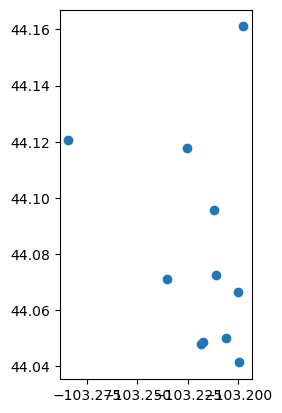

In [6]:
################################################################
#
# Fast and Dirty Plot of the GeoPandas GeoDataFrame
#

stations_df.plot()

#
################################################################

### Make a Fancier Plot

That doesn't help much.  If you pay a visit to the ["Rage-Quit 'Splainers" at my crying fort](https://wjcapehart.github.io/AES_CEE_Python/03%20Rage-Quit%20Explainers%20and%20Deep%20Dives.html#publication-quality-wrf-domain-mapping), you will see guidance on how to make nice maps.

The general steps are presented here. This is [mostly basic mapping in Python](https://wjcapehart.github.io/AES_CEE_Python/03%20Rage-Quit%20Explainers%20and%20Deep%20Dives.html#projecting-maps-not-psychological-in-python-and-trolling-flat-earthers).

* Drop a figure/"workstation" object with [matplotlib.pyplot.figure](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)
* Create a coordinate reference system with the [cartopy.crs.*](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html) group.  I prefer to use Transverse Mercator if I don't have any other requirements when I work with small local areas (from there, as a meteorologist for whom angle conformity is a priority, I will scale up to Lambert Conformal Conic).
* Apply that projection to a new subplot element with [matplotlib.figure.Figure.add_subplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.add_subplot.html)
* Now for the new steps:
    * Access a tile set for mapping.  I typically use either Google Maps or Open Science Maps (OSM) as I am doing here with [cartopy.io.img_tiles.OSM()](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.io.img_tiles.OSM.html)
    * Order the dropping of that image tile with a given "zoom" level with [cartopy.mpl.geoaxes.GeoAxes.add_image()](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html#cartopy.mpl.geoaxes.GeoAxes.add_image).  You will need to do a little trial and error to get the right "zoom" level.
    * When the map is rendered the tile source will be downloaded and integrated accordingly based on other arguments in the plot generation (e.g., the extent of the plot.
* From there we can drop the pandas coordinates with [geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) and close the map with labeling your plot [[matplotlib.axes.Axes.set_title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)] and seal the deal with 

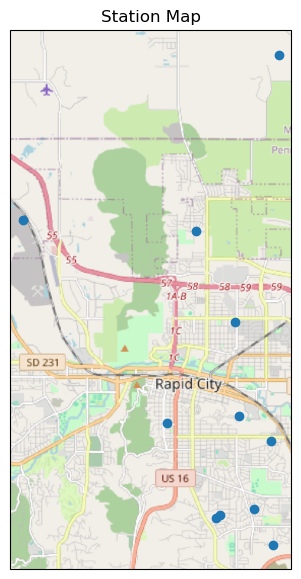

In [7]:
##############################################
#
# Make a map with Google Maps
#


fig = plt.figure(figsize=(11, 7))

# create a simple localized platform (I like Transverse Mercator customized on my location)

myproj = ccrs.TransverseMercator(central_latitude=stations_df["latitude"].mean(),
                                 central_longitude=stations_df["longitude"].mean())

# add a plot element just one field aka the "Axes"

ax = fig.add_subplot(1,  # nrows
                     1,  # ncols 
                     1,  # index of figure you're installing
                     projection = myproj)  # cartopy CRS Projection

# Request Map Tiles

map_tiles = cimgt.OSM(desired_tile_form="RGB")

# Lay down the map tiles 

ax.add_image(map_tiles, 12)

stations_df.plot(ax        =              ax, 
                 transform = ccrs.Geodetic())

# Good People Label their Plots

ax.set_title("Station Map")

# Display and Close Graph

plt.show()

#
##############################################

## Pulling A Single Station 

For us we will zero in on a single station, the current National Weather Service Office.  We can only pull one year per call to the CDO server (we can remedy this later by using loops and the [pandas.DataFrame.append()](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.DataFrame.append.html) command.

This initial section will presume that you are using the data once and will not be archiving it for others.  

If not, don't be a jerk.  Invest the time to archive the data in a more professional.  Below this, I will present a similar workflow, but there, the notebook will show best practices for general archiving time series data to the [Climate-Forecast Metadata Standard](https://cfconventions.org/), which will require the use of Xarray.

### The Data Request

Here, we will pull one year and slowly curate the data request into a working dataframe.  

We will start with the data request: [pyncei.bot.NCEIBot.get_data()](https://pyncei.readthedocs.io/en/latest/api.html#pyncei.bot.NCEIBot.get_data).


In [8]:
##############################################
#
# Extract a Year of Data and Place it into a Data Frame.
#

# Identify Station

stationid =  "GHCND:USC00396948"

# Station Metadata (if needed elsewhere)

mystation = stations_df.loc[stationid].to_dict()

# Identify a Year and then Start and End Dates

year = 2019

start_date = str(year).zfill(4) + "-01-01"
end_date   = str(year).zfill(4) + "-12-31"

# Generate a Data Request

data_request = ncei.get_data(datasetid = "GHCND",             # Dataset
                             stationid = "GHCND:USC00396948", # Station
                             startdate = start_date,          # Start Date
                             enddate   = end_date)            # End Date

#
##############################################

/opt/miniconda3/lib/python3.12/site-packages/pyncei/bot.py:765: UserWarning: No lookup list found for stations
  warnings.warn(f"No lookup list found for {endpoint}")


### Cleaning Pivoting the returned Data Frame.

We only need three columns: the date, weather type, and values of the weather type.  We'll then "pivot" the long data frame into a shorter-but-wider frame. with the [pandas.DataFrame.pivot()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html).

In this case, we will move the date to the "index" for the Data Frame, and the various datatypes will be made into their own personal columns and populated by the numbers in the "value" column. 

All units default to metric units.
*  Temperatures are in °C (not K)
*  Precipitation is in kg m⁻² (aka mm depth).

Note that the WTnn codes are typically seen at the end of a weather service or AFOS station request.  Most of the climate data stations won't have them.  When I archive data for keeps, I typically do not retain these fields.  

Most stations will return precipitation data and high and low daily temperatures.  They *may* have snow data.  From my experience when NCEI was NCDC and was in a much more interesting-looking building, if there *is* snow data, the older snow data may not be reliable.  The temperature at the time of observation is often not useful unless the metadata clearly shows an observation time.

In [9]:
##############################################
#
# Extract a Year of Data and Place it into a Data Frame.
#
# Retain only actual weather/climate data

data_request = data_request.to_dataframe()[[    "date",
                                            "datatype",
                                               "value"]]

# Time is Time, not Date, Day, Year, Hour, etc.

data_request.rename({"date":"time"}, axis="columns", inplace=True)


data_request = data_request.pivot(index   =     "time", 
                                  columns = "datatype", 
                                  values  =    "value")


data_request.sort_index(inplace=True)
data_request



#
##############################################

datatype    PRCP  SNOW  SNWD  TMAX  TMIN  TOBS  WT01  WT03  WT04  WT05  WT06  \
time                                                                           
2019-01-01   0.0   0.0  76.0  -5.6 -20.6  -9.4   NaN   NaN   NaN   NaN   NaN   
2019-01-02   0.0   0.0  76.0   5.0 -11.7  -0.6   NaN   NaN   NaN   NaN   NaN   
2019-01-03   0.0   0.0  25.0  10.0  -2.2   7.2   NaN   NaN   NaN   NaN   NaN   
2019-01-04   0.0   0.0   0.0  13.3   5.0   9.4   NaN   NaN   NaN   NaN   NaN   
2019-01-05   0.0   0.0   0.0  10.0   0.0   2.2   NaN   NaN   NaN   NaN   NaN   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2019-12-27   0.0   0.0   0.0   3.9  -7.8  -2.8   NaN   NaN   NaN   NaN   NaN   
2019-12-28   0.0   5.0   0.0  -2.2  -5.0  -5.0   NaN   NaN   NaN   NaN   NaN   
2019-12-29   0.5  10.0   0.0  -1.7  -5.0  -2.8   NaN   NaN   NaN   NaN   NaN   
2019-12-30   0.0   0.0   0.0   2.2  -3.3  -2.2   NaN   NaN   NaN   NaN   NaN   
2019-12-31   0.0   0.0   0.0   5.6  -3.9   3.9   NaN   NaN   NaN   NaN   NaN   

datatype    WT11  
time              
2019-01-01   NaN  
2019-01-02   NaN  
2019-01-03   NaN  
2019-01-04   NaN  
2019-01-05   NaN  
...          ...  
2019-12-27   NaN  
2019-12-28   NaN  
2019-12-29   NaN  
2019-12-30   NaN  
2019-12-31   NaN  

[365 rows x 12 columns]

And we can close our business with a couple plots leveraging Seaborn to make the plots a little prettier.

I'm annotating the data

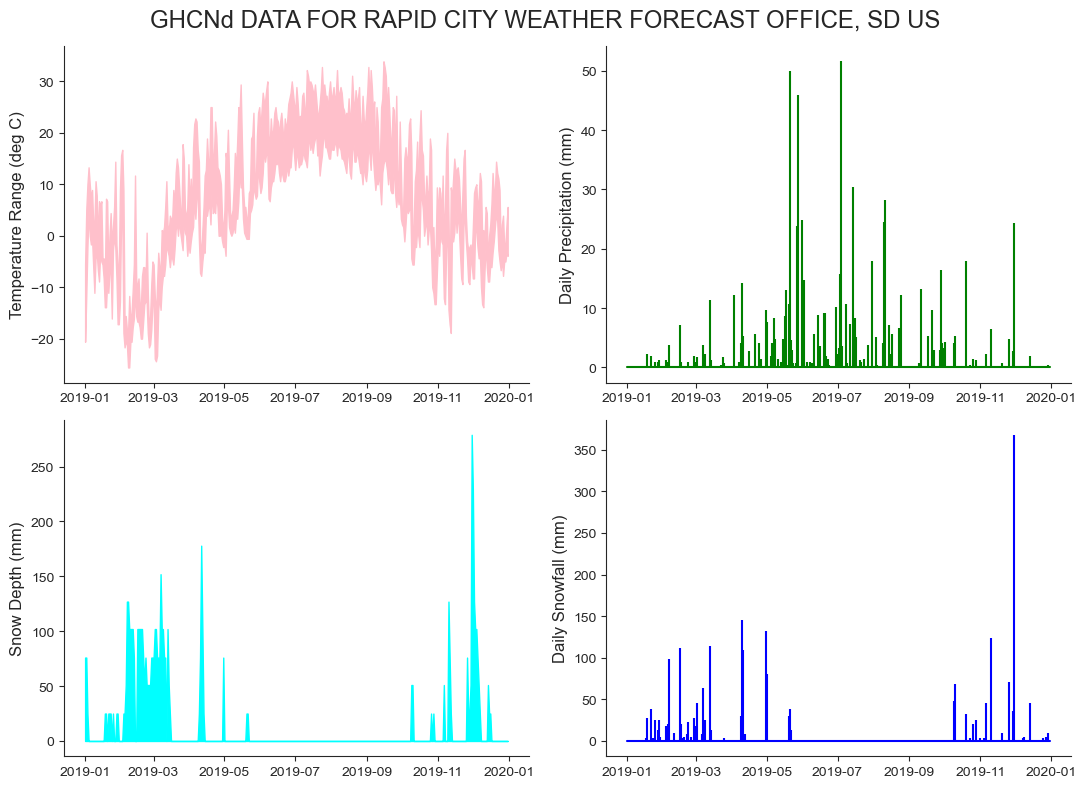

In [10]:
##############################################
#
# Plotting a 4-panel plot.
#

# Select a Seaborn Theme (I like "ticks")

sns.set_style("ticks")

# Create a 2x2 4-panel graph that's 11x8 "inches" in size

fig, ax  = plt.subplots(nrows   =      2,
                        ncols   =      2, 
                        figsize = [11,8])

# Label the top of the graph (that's why we retained the station metadata!)

fig.suptitle(("GHCNd DATA FOR "+mystation["name"]),
             fontsize = "xx-large")

# Panel 1 (Upper Left; 0,0): Temperature "ribbon plot" filled
#    between two variables

ax[0,0].fill_between(x  = data_request.index,
                     y1 = data_request["TMAX"],
                     y2 = data_request["TMIN"],
                     color = "pink")
ax[0,0].set_ylabel("Temperature Range (deg C)",
                   fontsize = "large")

# Panel 2 (Upper Right; 0,1): a Precipitation "stem" plot  
#    to mimic a vertical bar plot as we should always do
#    for precip!

ax[0,1].stem(data_request.index,
             data_request["PRCP"],
             markerfmt="None",
             linefmt="g",
             basefmt="g")

ax[0,1].set_ylabel("Daily Precipitation (mm)",
                   fontsize = "large")

# Panel 3 (Lower Left; 1,0): another fill between (this time
#   grounded at zero for Snow Depth

ax[1,0].fill_between(x  = data_request.index,
                     y1 = data_request["SNWD"],
                     y2 = 0,
                     color = "cyan")

ax[1,0].set_ylabel("Snow Depth (mm)",
                   fontsize = "large")

# Panel 4 (Lower Right; 1,1): as a form of precipitation
#   we also use bars (or stems) for snowfall.  Notice also this is 
#   acutal snowfall depth, not snow-water equivalent.

ax[1,1].stem(data_request.index,
             data_request["SNOW"],
             markerfmt="None",
             linefmt="b",
             basefmt="b")
ax[1,1].set_ylabel("Daily Snowfall (mm)",
                   fontsize = "large")

sns.despine()
plt.tight_layout()
plt.show()

#
##############################################

---
---

## Formal Archiving the Data For the Ages

If you are using this for you and only you are not obligated to archive the data for future work, you are done with this demonstration.

If you are creating or must create "data for the ages, " you should take a more rigorous approach. Here, we will take the existing data frame and use my tools from other scripts to create a more formal netCDF file that can be archived on a THREDDS service and otherwise easily readable and understandable by your peers.

In an actual application, all of this would be coded in a nested loop system and saved as a traditional Python script so any graphics and notebook tools would be removed.

In this case, we will make a CF-compliant file for a [Single Station Time Series](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.12/cf-conventions.html#_single_time_series_including_deviations_from_a_nominal_fixed_spatial_location).

### MetaData for NetCDF Files.

It's easiest to put variable metadata into data frames or dictionaries.  

Here, we will place the LUTs for the Data Variable Names (which will be stored as CF Metadata Standard standard_names, long_names, descriptions, and units).  

In [11]:
##############################################
#
# LUT/Metadata Tables
#

GHCND_to_variable_names = {"TMAX":"maximum_air_temperature",
                           "TMIN":"minimum_air_temperature",
                           "TAVG":"mean_air_temperature",
                           "PRCP":"precipitation_amount",
                           "SNOW":"thickness_of_snowfall_amount",
                           "SNWD":"surface_snow_thickness",
                           "WESD":"liquid_water_content_of_surface_snow",
                           "WESF":"liquid_water_equivalent_snowfall_amount",
                           "AWND":"mean_wind_speed",
                           "AWDR":"mean_wind_from_direction"}

GHCND_to_standard_names = {"TMAX":"air_temperature",
                           "TMIN":"air_temperature",
                           "TAVG":"air_temperature",
                           "PRCP":"precipitation_amount",
                           "SNOW":"thickness_of_snowfall_amount",
                           "SNWD":"surface_snow_thickness",
                           "WESD":"liquid_water_content_of_surface_snow",
                           "WESF":"liquid_water_equivalent_snowfall_amount",
                           "AWND":"mean_wind_speed",
                           "AWDR":"mean_wind_from_direction"}

GHCND_to_long_names     = {"TMAX":"2-m Maximum Daily Air Temperature",
                           "TMIN":"2-m Minimium Daily Air Temperature",
                           "TAVG":"2-m Mean Daily Air Temperature",
                           "PRCP":"Daily Total Precipitation",
                           "SNOW":"Daily Total Snowfall",
                           "SNWD":"Snow Depth on Surface",
                           "WESD":"Liquid Snow Water Equivalent Depth on Surface",
                           "WESF":"Liquid Snowfall Water Equivalent Depth on Surface",
                           "AWND":"Mean Daily Wind Speed",
                           "AWDR":"Mean Daily Wind Origin Direction"}

GHCND_to_units          = {"TMAX":"degC",
                           "TMIN":"degC",
                           "TAVG":"degC",
                           "PRCP":"kg m-2",
                           "SNOW":"kg m-2",
                           "SNWD":"kg m-2",
                           "WESD":"kg m-2",
                           "WESF":"kg m-2",
                           "AWND":"m s-1",
                           "AWDR":"degrees_from"}

GHCND_to_cellmethods    = {"TMAX":"time:maximum",
                           "TMIN":"time:minimum",
                           "TAVG":"time:mean",
                           "PRCP":"time:sum",
                           "SNOW":"time:sum",
                           "SNWD":"time:point",
                           "WESD":"time:point",
                           "WESF":"time:sum",
                           "AWND":"time:mean",
                           "AWDR":"time:mean"}

# also including our half-day increment to set time-bounds

half_day = np.int64(43200000000000).astype("timedelta64[ns]")
    
#
##############################################

### Convert Pandas DataFrame to XArray DataSet

The first part is easy:  Convert the Pandas DataFrame to an XArray Dataset.  The "index" for the Pandas DataFrame will become the Coordinate of the XArray Dataset.


In [12]:
##############################################
#
# Create DataSet
#
# 

ds = data_request.to_xarray()

ds
#
##############################################

<xarray.Dataset> Size: 38kB
Dimensions:  (time: 365)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    PRCP     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.5 0.0 0.0
    SNOW     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 5.0 10.0 0.0 0.0
    SNWD     (time) float64 3kB 76.0 76.0 25.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TMAX     (time) float64 3kB -5.6 5.0 10.0 13.3 10.0 ... -2.2 -1.7 2.2 5.6
    TMIN     (time) float64 3kB -20.6 -11.7 -2.2 5.0 0.0 ... -5.0 -5.0 -3.3 -3.9
    TOBS     (time) float64 3kB -9.4 -0.6 7.2 9.4 2.2 ... -5.0 -2.8 -2.2 3.9
    WT01     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan
    WT03     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan
    WT04     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan
    WT05     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan
    WT06     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan
    WT11     (time) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan

### Trimming the XArray Dataset

If we have more variables in the original request results, we can remove them here.


In [13]:
##############################################
#
# Drop variables not expected to be retained
#

# extract our variables from our data frame and our netcdf 
#   metadata dictionaries

retainable_variables = list(GHCND_to_units.keys())
variables_in_ds      = list(ds.keys())

# find the intersecting and odd-men-out variables

dropped_variables   = list(set(variables_in_ds).difference(retainable_variables))
available_variables = list(set(variables_in_ds).intersection(retainable_variables))

# drop the unwanted variables

ds = ds.drop_vars(dropped_variables)

ds

#
##############################################

<xarray.Dataset> Size: 18kB
Dimensions:  (time: 365)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    PRCP     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.5 0.0 0.0
    SNOW     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 5.0 10.0 0.0 0.0
    SNWD     (time) float64 3kB 76.0 76.0 25.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TMAX     (time) float64 3kB -5.6 5.0 10.0 13.3 10.0 ... -2.2 -1.7 2.2 5.6
    TMIN     (time) float64 3kB -20.6 -11.7 -2.2 5.0 0.0 ... -5.0 -5.0 -3.3 -3.9

### Adding the Attributes to our Data Frame

The whole point of making a netCDF file is that you don't have to remember what units your variables are in and so that other people using your data will be able to see this information.  

That means attributes.  

Here, we load the essential attributes into our variables and add them to our time coordinate.

Notice also that we are adding bounds to our time values using the [xarray.Dataset.cf.add_bounds()](https://cf-xarray.readthedocs.io/en/latest/generated/xarray.Dataset.cf.add_bounds.html) tool.

Finally, we will change the names of our variables from the ones used in CDO to less ambiguous ones based on the CF Metadata Standard Names.

In [14]:
##############################################
#
# Load Attributes into Variables
#

for variable in available_variables:
    ds[variable].attrs["long_name"]     = GHCND_to_long_names[variable]
    ds[variable].attrs["description"]   = GHCND_to_long_names[variable]
    ds[variable].attrs["standard_name"] = GHCND_to_standard_names[variable]
    ds[variable].attrs["units"]         = GHCND_to_units[variable]
    ds[variable].attrs["cell_methods"]  = GHCND_to_cellmethods[variable]
    ds[variable].attrs["coordinates"]   = "time lat lon alt station_id"
# Time attributes (also moving the time to the center of the day)

ds["time"].attrs["long_name"]          = "time"
ds["time"].attrs["description"]        = "time"
ds["time"].attrs["standard_name"]      = "time"
ds["time"].attrs["bounds"]             = "time_bounds"
ds["time"]                             = ds["time"] + half_day

# adding time bounds

ds = ds.cf.add_bounds(keys="time")
ds["time_bounds"].attrs["long_name"]   = "time bounds"
ds["time_bounds"].attrs["description"] = "time bounds"

# swap CDO variable names for more formal names

filtered_dict = dict((k, GHCND_to_variable_names[k]) for k in available_variables if k in GHCND_to_variable_names)

ds = ds.rename_vars(filtered_dict)

ds

#
##############################################

<xarray.Dataset> Size: 23kB
Dimensions:                       (time: 365, bounds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2019-01-01T12:00:...
    time_bounds                   (time, bounds) datetime64[ns] 6kB 2019-01-0...
Dimensions without coordinates: bounds
Data variables:
    precipitation_amount          (time) float64 3kB 0.0 0.0 0.0 ... 0.5 0.0 0.0
    thickness_of_snowfall_amount  (time) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0
    surface_snow_thickness        (time) float64 3kB 76.0 76.0 25.0 ... 0.0 0.0
    maximum_air_temperature       (time) float64 3kB -5.6 5.0 10.0 ... 2.2 5.6
    minimum_air_temperature       (time) float64 3kB -20.6 -11.7 ... -3.3 -3.9

In [15]:
##############################################
#
# Creating the remaining variables and attributes needed
#   for a CF-Metadata Time Series.
#

# Pull our metadata for our requested station

mystation = stations_df.loc[stationid].to_dict()

# Get our location data loaded

ds["lat"]      = xr.DataArray(data  = mystation["latitude"],
                              attrs = {"long_name"    :"latitude",
                                       "description"  :"latitude",
                                       "standard_name":"latitude",
                                       "units"        :"degrees_north"})

ds["lon"]      = xr.DataArray(data  = mystation["longitude"],
                              attrs = {"long_name"    :"longitude",
                                       "description"  :"longitude",
                                       "standard_name":"longitude",
                                       "units"         :"degrees_east"})

ds["alt"]      = xr.DataArray(data  = mystation["elevation"],
                              attrs = {"long_name"    :"station elevation",
                                       "description"  :"station elevation",
                                       "standard_name":"height",
                                       "positive"     :"up",
                                       "axis"         :"Z",
                                       "units"        :"m"})

ds["station_name"]      = xr.DataArray(data  = mystation["name"],
                              attrs = {"long_name"    :"station name",
                                       "description"  :"station name"})
ds["station_id"]      = xr.DataArray(data  = stationid,
                              attrs = {"long_name"    :"station id",
                                       "description"  :"station id",
                                       "description"  :"timeseries_id"})


ds.attrs["title"]                       = "Global Historical Climatology Network daily (GHCNd)" 
ds.attrs["institution"]                 = "NOAA Center for Environmental Prediction (NCEI)" 
ds.attrs["title"]                       = "Global Historical Climatology Network daily (GHCNd)" 
ds.attrs["references"]                  = "https://doi.org/10.1175/JTECH-D-11-00103.1" 
ds.attrs["url"] = "https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily"
ds.attrs["GHCN_Station_Code"]           = stationid
ds.attrs["Station_Name"]                = mystation["name"]
ds.attrs["Station_Latitude"]            = mystation["latitude"]
ds.attrs["Station_Longitude"]           = mystation["longitude"]
ds.attrs["Station_Elevation_in_Meters"] = mystation["elevation"]
ds.attrs["Conventions"]                 = "CF-1.12"
ds.attrs["featureType"]                 = "timeSeries"

#  GHCND-ASN00001000__KARUNJIE_AS.nc

filename = (stationid+"__"+mystation["name"]+".nc").replace(":", "-").replace(", ", "_").replace(" ", "_")

print("saving filename "+filename)
ds.close()
ds.to_netcdf(path           = filename,
             unlimited_dims = "time",
             engine         = "h5netcdf",
             encoding       = {"time":       {"units":"seconds since 1970-01-01 00:00:00",
                                              "dtype":np.float64},
                               "time_bounds":{"units":"seconds since 1970-01-01 00:00:00",
                                              "dtype":np.float64}})
ds.close()

ds

saving filename GHCND-USC00396948__RAPID_CITY_WEATHER_FORECAST_OFFICE_SD_US.nc


<xarray.Dataset> Size: 24kB
Dimensions:                       (time: 365, bounds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2019-01-01T12:00:...
    time_bounds                   (time, bounds) datetime64[ns] 6kB 2019-01-0...
Dimensions without coordinates: bounds
Data variables:
    precipitation_amount          (time) float64 3kB 0.0 0.0 0.0 ... 0.5 0.0 0.0
    thickness_of_snowfall_amount  (time) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0
    surface_snow_thickness        (time) float64 3kB 76.0 76.0 25.0 ... 0.0 0.0
    maximum_air_temperature       (time) float64 3kB -5.6 5.0 10.0 ... 2.2 5.6
    minimum_air_temperature       (time) float64 3kB -20.6 -11.7 ... -3.3 -3.9
    lat                           float64 8B 44.07
    lon                           float64 8B -103.2
    alt                           float64 8B 1.03e+03
    station_name                  <U41 164B 'RAPID CITY WEATHER FORECAST OFFI...
    station_id                    <U17 68B 'GHCND:USC00396948'
Attributes:
    title:                        Global Historical Climatology Network daily...
    institution:                  NOAA Center for Environmental Prediction (N...
    references:                   https://doi.org/10.1175/JTECH-D-11-00103.1
    url:                          https://www.ncei.noaa.gov/products/land-bas...
    GHCN_Station_Code:            GHCND:USC00396948
    Station_Name:                 RAPID CITY WEATHER FORECAST OFFICE, SD US
    Station_Latitude:             44.0727
    Station_Longitude:            -103.2108
    Station_Elevation_in_Meters:  1029.9
    Conventions:                  CF-1.12
    featureType:                  timeSeries

# Version Information

*Version Information* is a package developed by J.R. Johansson and operates as what the iPython/Jupyter Environments calls ["Magic Line" commands](https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html) which are invoked by a "%."  This one is convenient since it displays detailed information on the versions of Python, Jupyter, and any other denoted packages (but for those, you DO need to delete them since this is running "outside" of your notebook program.

The output will be in JSON format in the Jupyter Lab Notebook, but it will be a professional-looking table when rendered as an HTML file.

In [16]:
################################################################
#
# Loading Version Information
#

%load_ext version_information
%version_information numpy, matplotlib, pandas, geopandas, cartopy, xarray, cf_xarray, pyncei, itables, version_information

#
################################################################

Software,Version
Python,3.12.8 64bit [Clang 18.1.8 ]
IPython,8.30.0
OS,macOS 15.1.1 arm64 arm 64bit
numpy,1.26.4
matplotlib,3.8.4
pandas,2.2.2
geopandas,1.0.1
cartopy,0.24.0
xarray,2024.11.0
cf_xarray,0.10.0
